In [82]:
import pandas as pd
import itertools
# filename = '2019_2020_top_10.csv'
filename = 'top_100_users_pushes.csv'
df = pd.read_csv(f'../segmentation/{filename}', index_col='pusher_id', keep_default_na=False)
df = df.loc[df['push_tag'] != '']
df.head()

,board,article_timestamp,article_author,article_id,article_title,article_content,push_content,push_ip,push_tag,push_timestamp
pusher_id,,,,,,,,,,


In [25]:
art_df = pd.read_csv(f'../segmentation/{filename}', index_col='article_author', keep_default_na=False)
art_df = art_df.loc[art_df['pusher_id'] == '']
art_df.head()

,board,article_timestamp,article_id,article_title,article_content,push_content,push_ip,push_tag,pusher_id,push_timestamp
article_author,,,,,,,,,,
GGrunrundela,Gossiping,2019-12-14 16:15:27,M.1576311329.A.383,[問卦] 欸 肥宅用p助的卡能吸淫到妹子嗎？,欸\n\n我說那個呀\n\n你個位的醜八怪、奈米屌、醜男、北七噁爛眾肥宅們晚安\n\n\n\...,,,,,
GGrunrundela,Gossiping,2019-12-17 14:14:32,M.1576563274.A.5D0,[問卦] 男同事問我聖誕節有沒有要幹嘛??,安安安\n\n肥宅我 剛剛午休跟男同事聊天\n\n聊一聊就聊到床ㄕ.. 阿 不是喇 就聊到聖...,,,,,
astrayzip,Gossiping,2019-12-01 03:52:58,M.1575143580.A.E6E,[問卦] 做夢體感時間越來越長該怎麼辦,大家好\n\n我朋友是個醫生辣\n\n前陣子說他有個病患\n\n說夢裡的體感時間越來越長\n...,,,,,
astrayzip,Gossiping,2019-12-01 15:28:49,M.1575185331.A.2EA,[問卦] 魚長腳跑到路上該怎辦,安安\n\n我朋友日本人辣\n\n他剛剛說他跟女朋友出去玩\n\n結果不知道為啥\n\n有很...,,,,,
astrayzip,Gossiping,2019-12-02 14:22:18,M.1575267740.A.A8A,[問卦] 炭治郎真的就這樣瞎了後死了嗎,無慘用高速觸手打爆炭治郎的眼睛\n\n又塗毒攻擊炭讓他中鬼毒\n\n現在炭，就快要死掉了\n...,,,,,


In [91]:
from datetime import datetime

users = list(set(df.index))
art_users = list(set(art_df.index))

def parse_timestamp(push_timestamp):
    [date, time] = push_timestamp.split()
    time = datetime.strptime(time, '%H:%M:%S').hour
    return {'date': date, 'time': time}

def to_data(data):
    if len(data) == 2:
        return {'tag': data[0], **parse_timestamp(data[1])}
    return {'tag': '', **parse_timestamp(data[0])}

def get_activity(user):
    return list(map(to_data, df.loc[[user], ['push_tag', 'push_timestamp']].values.tolist()))

def get_art_activity(user):
    return list(map(to_data, art_df.loc[[user], ['article_timestamp']].values.tolist()))

activities = [get_activity(u) for u in users] + [get_art_activity(u) for u in art_users]
# preview
activities[0][:5]

[{'tag': '推', 'date': '2019-12-01', 'time': 17},
 {'tag': '噓', 'date': '2019-12-01', 'time': 17},
 {'tag': '噓', 'date': '2019-12-01', 'time': 19},
 {'tag': '噓', 'date': '2019-12-01', 'time': 19},
 {'tag': '噓', 'date': '2019-12-02', 'time': 9}]

In [92]:
from functools import reduce
from collections import Counter

def get_online_activity(activity):
    return list(map(lambda x: json.loads(x), set((map(lambda x: json.dumps({'date': x['date'], 'time': x['time']}), activity)))))

# serialization is for unique the list, after encoding it we have to decode it
online_activities = [get_online_activity(a) for a in activities]

def get_online_times(activity):
    return Counter(a['time'] for a in activity)

online_activities = [[get_online_times(oa).get(i, 0) for i in range(24)] for oa in online_activities]
print(online_activities)

[[0, 0, 0, 0, 0, 0, 1, 16, 20, 21, 20, 21, 19, 21, 20, 22, 20, 15, 6, 7, 2, 2, 0, 0], [4, 3, 3, 1, 0, 0, 1, 2, 2, 5, 8, 11, 13, 6, 9, 8, 11, 8, 12, 11, 7, 5, 6, 3], [18, 21, 16, 16, 12, 7, 5, 5, 2, 1, 2, 1, 2, 6, 9, 14, 19, 18, 17, 17, 15, 12, 18, 18], [8, 6, 5, 1, 0, 0, 0, 1, 9, 13, 10, 6, 12, 9, 12, 12, 8, 14, 12, 11, 8, 6, 12, 15], [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 6, 5, 5, 5, 4, 5, 10, 4, 3, 4, 0, 2, 3], [6, 0, 0, 0, 0, 0, 0, 12, 24, 29, 30, 31, 24, 27, 23, 26, 28, 22, 14, 26, 19, 23, 23, 20], [15, 8, 1, 0, 0, 0, 2, 11, 14, 13, 11, 12, 7, 8, 9, 9, 6, 8, 9, 11, 10, 13, 11, 15], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [17, 20, 13, 13, 8, 2, 0, 1, 4, 8, 10, 12, 12, 12, 16, 18, 17, 16, 19, 19, 17, 17, 11, 17], [1, 0, 0, 0, 0, 1, 1, 1, 3, 11, 22, 18, 22, 22, 15, 20, 18, 19, 15, 13, 6, 8, 16, 9], [1, 0, 0, 0,

In [96]:
import numpy as np
from sklearn.manifold import TSNE

X = np.array(online_activities)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded

array([[ 1.3125092 , -4.8769927 ],
       [ 0.9036586 , -0.63313246],
       [-1.8549501 , -2.0124242 ],
       [ 0.77853084, -1.9638379 ],
       [ 5.886775  ,  6.576011  ],
       [ 1.686887  ,  2.2484307 ],
       [-0.73285407, -5.66049   ],
       [ 1.0021086 , -2.109851  ],
       [ 3.4657986 ,  8.952041  ],
       [ 5.360119  ,  9.149958  ],
       [-1.5348581 , -2.6853838 ],
       [ 0.49910057, -3.885593  ],
       [ 5.413479  ,  4.2578664 ],
       [-0.96285325, -4.672043  ],
       [-0.87970513, -5.134816  ],
       [-0.17379431, -3.4012232 ],
       [ 0.84663475, -1.309794  ],
       [ 4.5807905 ,  8.683463  ],
       [ 3.901751  ,  8.875886  ],
       [ 5.040387  ,  8.465006  ],
       [ 4.4396048 ,  6.90521   ],
       [ 0.7093091 , -4.7784557 ],
       [ 2.0459974 ,  4.7791376 ],
       [ 1.4631164 ,  0.7807208 ],
       [ 5.4169717 ,  8.381399  ],
       [ 3.0759003 ,  6.032225  ],
       [ 2.668691  ,  7.0268755 ],
       [ 0.01352231, -3.5730126 ],
       [-1.6668833 ,

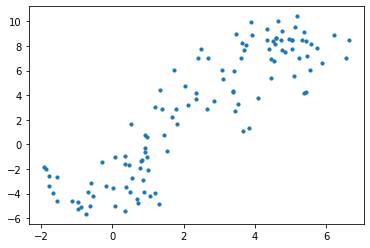

In [102]:
import matplotlib.pyplot as plt
 
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=10)
# plt.xlabel(f'perplexity: {PERPLEXITY}\nn_iter: 1000')
plt.show()

In [95]:
set(df['push_tag'])

{'→', '噓', '推'}